In [26]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from climatetranslation.qm.quantile_mapping import CDF, QauntileMapping

Make an extreme skewed distribution like precip

In [27]:
def percentile_cipped_pareto(a, shape, percentile):
    x = np.random.pareto(a, shape)
    c = np.percentile(x, percentile)
    return x.clip(c)  - c

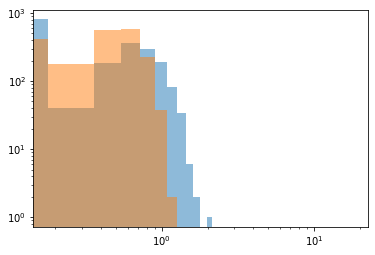

In [28]:
N = 2000

x = percentile_cipped_pareto(3, N, 40)#**0.25
y = percentile_cipped_pareto(8, N, 20)#**0.25

vmax = max(x.max(), y.max())

plt.hist(x**.25, bins=100, range=(0, vmax), alpha=0.5)
plt.hist(y**.25, bins=100, range=(0, vmax), alpha=0.5)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [29]:
eps = 0.001
n_quantiles = 100
quantiles = np.linspace(eps, 1-eps, n_quantiles)

In [30]:
dt = pd.date_range(start="2000-01-01", freq='D', periods=N)
ds_x = xr.DataArray(x[...,None, None, None], coords=dict(time=dt, run=[1], lat=[1], lon=[1]), dims=['time', 'run', 'lat', 'lon']).to_dataset(name='pr')
ds_y = xr.DataArray(y[...,None, None, None], coords=dict(time=dt, run=[1], lat=[1], lon=[1]), dims=['time', 'run', 'lat', 'lon']).to_dataset(name='pr')

In [31]:
ds_x

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, run: 1, time: 2000)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2005-06-22
  * run      (run) int64 1
  * lat      (lat) int64 1
  * lon      (lon) int64 1
Data variables:
    pr       (time, run, lat, lon) float64 0.1254 0.9341 0.3813 ... 0.0 0.5173

In [32]:
cdf_x = CDF(quantiles)
cdf_y = CDF(quantiles)

In [33]:
cdf_x.fit(ds_x)
cdf_y.fit(ds_y)

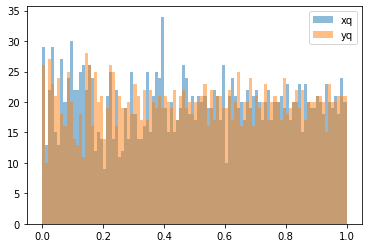

In [34]:
ds_xq = cdf_x.transform(ds_x)
ds_yq = cdf_y.transform(ds_y)

xq = ds_xq.pr.values.flatten()
yq = ds_yq.pr.values.flatten()

vmax = 1

def hist(z, **kwargs):
    plt.hist(z, bins=100, range=(0, vmax), alpha=0.5, **kwargs)

hist(xq, label='xq')
hist(yq, label='yq')

#plt.xscale('log')
#plt.yscale('log')
plt.legend()

In [35]:
qm = QauntileMapping(cdf_x, cdf_y)

In [36]:
ds_x2y = qm.transform_a2b(ds_x)
ds_y2x = qm.transform_b2a(ds_y)

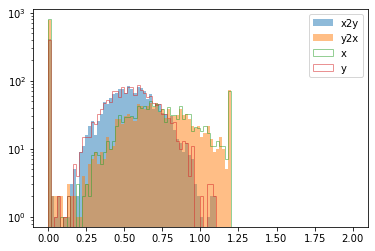

In [37]:
x2y = ds_x2y.pr.values.flatten()
y2x = ds_y2x.pr.values.flatten()

vmax = 2#max(x2y.max(), y2x.max())

def hist(z, **kwargs):
    plt.hist(np.clip(z, 0, vmax)**.25, bins=100, range=(0, vmax), alpha=0.5, **kwargs)

hist(x2y, label='x2y')
hist(y2x, label='y2x')

hist(x, histtype='step', label='x')
hist(y, histtype='step', label='y')

#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()